In [76]:
import numpy as np
import open3d as o3d
import nrrd
import os
import matplotlib.pyplot as plt
import cv2
from sklearn import preprocessing
from scipy.ndimage import zoom
from collections import Counter
from PIL import Image
#path='C:/Users/56-000M100-32/Arthur/datasets_graz/graz/Mandibular_Datasets/'
gt_dir='C:/Users/56-000M100-32/Arthur/CogitoGT/nrrd/'#Pat2block.nrrd'
raw_dir='C:/Users/56-000M100-32/Arthur/datasets_graz/graz/Mandibular_Datasets/'#Pat2block.nrrd'
pred_dir='C:/Users/56-000M100-32/Arthur/1110prediction/'#0825_sz128_dist25_thd400_Pat2Block.pth.txt'
data_dir='C:/Users/56-000M100-32/Arthur/ct-base/ct_dataset/1007dataset_clearnone/pointcloud_data_xyz/'#0825_sz128_dist25_thd400_Pat2Block.txt'
header='0825_sz128_dist25_thd400_'
write_dir='C:/Users/56-000M100-32/Arthur/CogitoGT/np_128/'
# Some sample numpy data
subjects=os.listdir(gt_dir)
#print(subjects)

In [77]:
gt_mapping={0: 0, #"Clear Label"
             1: 1,#"mandible"
             2: 3,#"Right maxilla"
             3: 10,#"Abiotic"
             4: 2,# "Right zygometic"
             5: 7,#"Right sphenoid"
             6: 3,#"Left mexilla"
             7: 2,#"Left zygometic"
             8: 8,#?
             9: 7,#"Left sphenoid"
             10: 5,#"Right temporal"
             11: 5,#"Left temporal"
             12: 12,#?
             13: 6,#"Parietal"
             14: 8,#"Occipital"
             15: 15,#?
             16: 9#"Spine"
           }


In [78]:
def get_raw(path):
    readdata, header = nrrd.read(path)
    raw = np.einsum('ijk->kji', readdata)
    
    return np.array(raw)

In [79]:
def get_gt(path):
    readdata, header = nrrd.read(path)
    gt = np.einsum('ijk->kji', readdata)
    return np.array(gt)

In [80]:
def get_pred(path):
    r=open(path,'r')
    label=np.genfromtxt(r,delimiter=",",usemask=True)
    return np.array(label)

In [81]:
def greyscale_filter(raw,gt):
    colors= raw.flatten()
    eyebox_color = Counter(colors).most_common()
    for i in eyebox_color:
        if i[0]>0:
            print(i)
            break
    target = i[0]
    for i in range(len(gt)):
        idx=np.where(raw[i]==target)
        gt[i][idx]=0
        raw[i][idx]=-1000
        
    
    return np.array(raw), np.array(gt)
   
    

In [82]:
def convert_label(gt):
    for z in range(gt.shape[0]):
        for y in range(gt.shape[1]):
            for x in range(gt.shape[2]):
                gt[z][y][x]=gt_mapping[int(gt[z][y][x])]
    return np.array(gt)

In [83]:
def seperate_class(gt):
    masks=np.zeros((11,len(gt),512,512))
    #a=gt.flatten()
    #print(a.max())
    print(masks.shape)
    for z in range(gt.shape[0]):
        for y in range(gt.shape[1]):
            for x in range(gt.shape[2]):
                masks[gt_mapping[int(gt[z][y][x])]][z][y][x]=1
    return masks

In [84]:
def get_threshold(old_threshold,old_info,new_info):
    
    #_info = [max,mean,min,std]
    factor=(old_threshold-old_info[1])/old_info[3]
    new_threshold=new_info[1]+new_info[3]*factor  
    
    return new_threshold

Pat2block.nrrd
(154, 512, 512)
(154, 512, 512)
(1024, 2381748)
(154, 512, 512) (154, 512, 512)
old:  [3059, -523.4973710790857, -1024, 540.6328288387075]
new:  [2899, -525.8165917396545, -1575, 539.654661985189]
(128, 128, 128)
396.0098957572385 400
(11, 154, 512, 512)
(154, 512, 512)


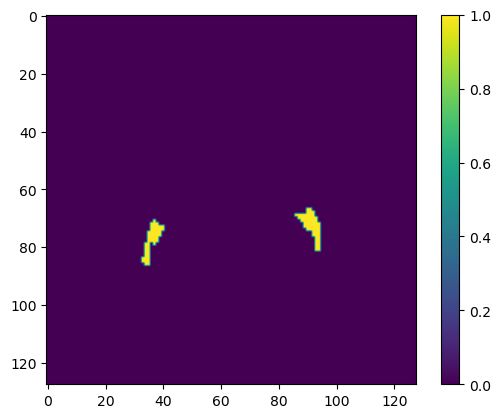

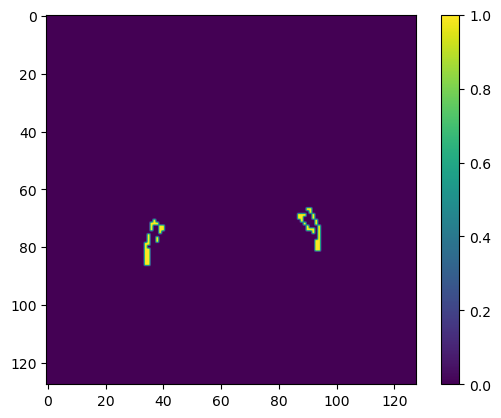

(128, 128, 128)
(154, 512, 512)


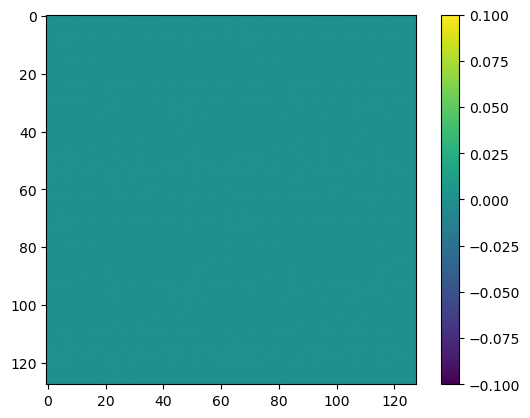

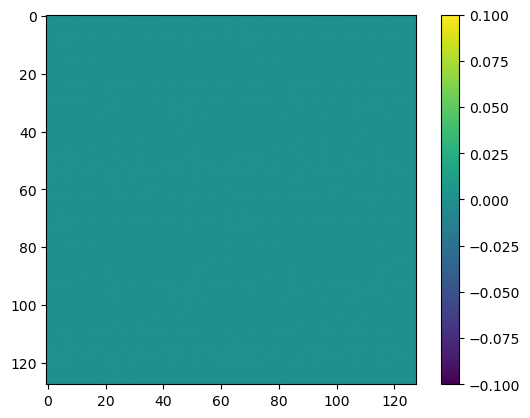

(128, 128, 128)
(154, 512, 512)


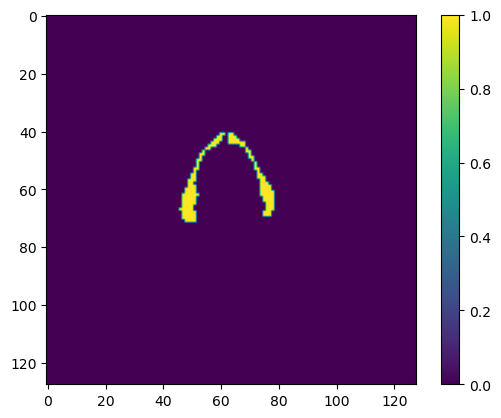

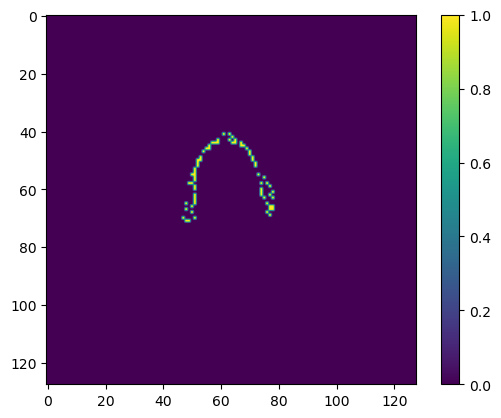

(128, 128, 128)
(154, 512, 512)


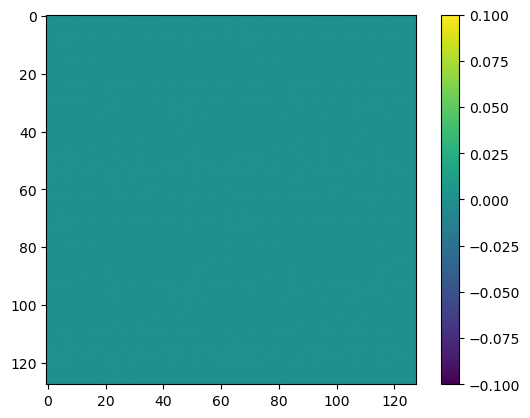

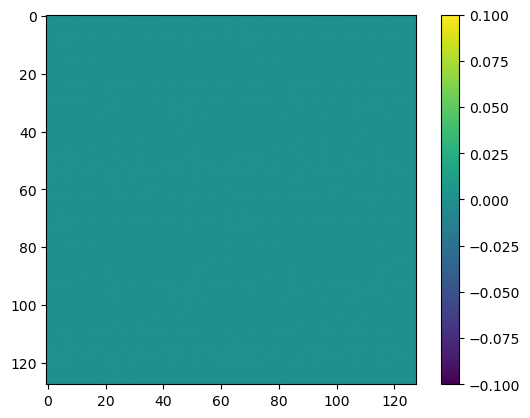

(128, 128, 128)
(154, 512, 512)


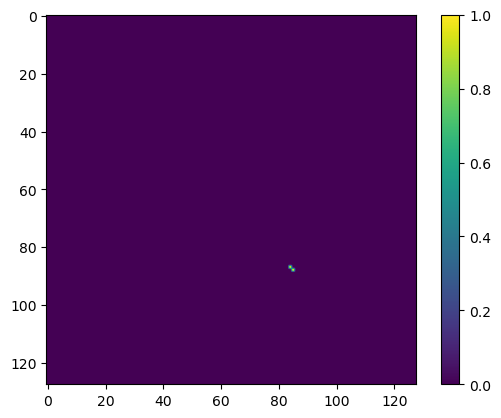

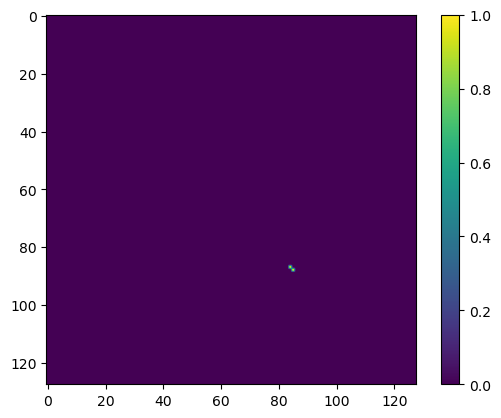

(128, 128, 128)
(154, 512, 512)


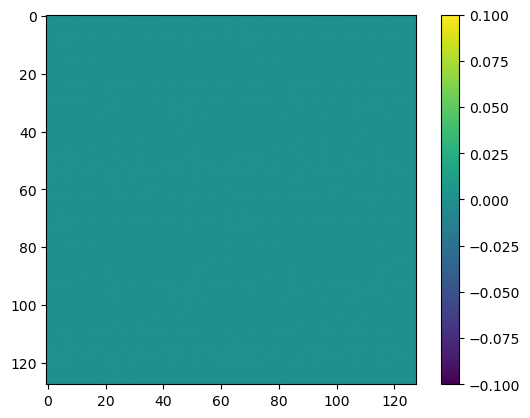

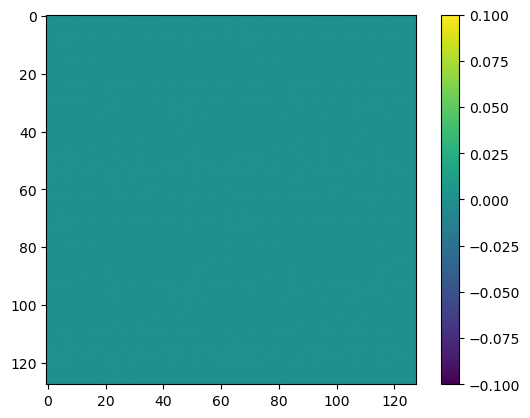

(128, 128, 128)
(154, 512, 512)


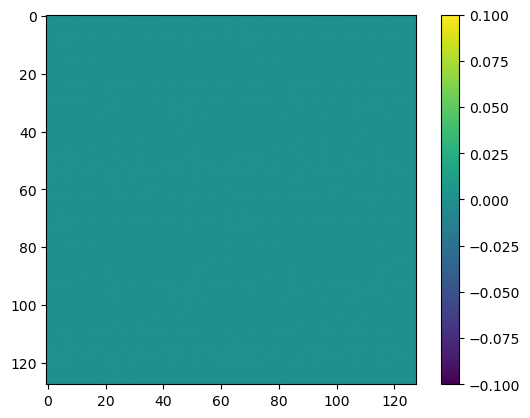

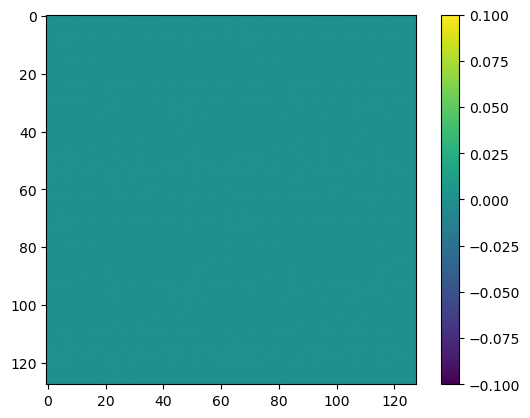

(128, 128, 128)
(154, 512, 512)


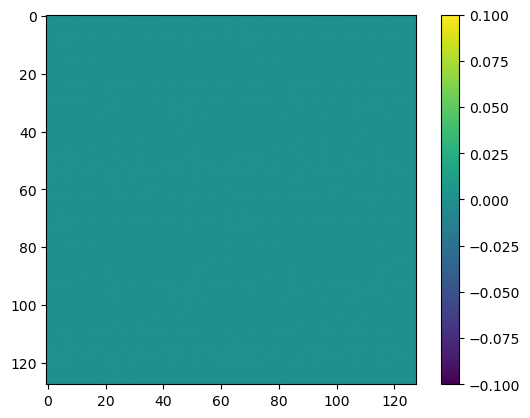

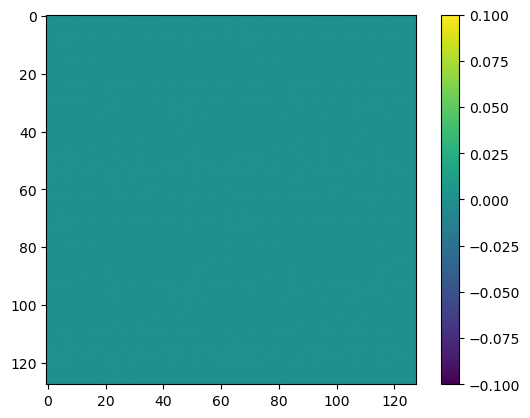

(128, 128, 128)
(154, 512, 512)


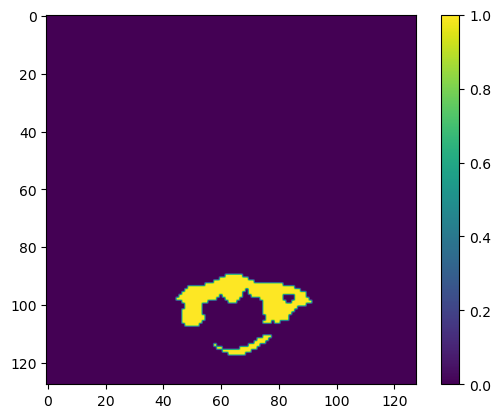

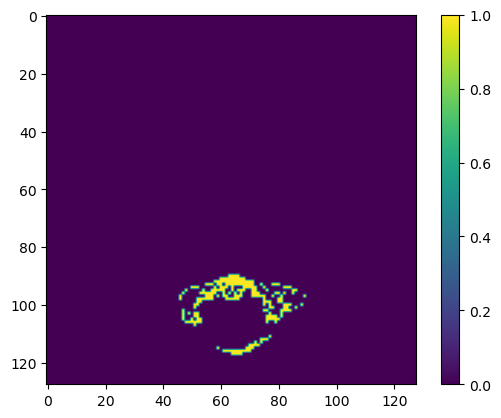

(128, 128, 128)
(154, 512, 512)


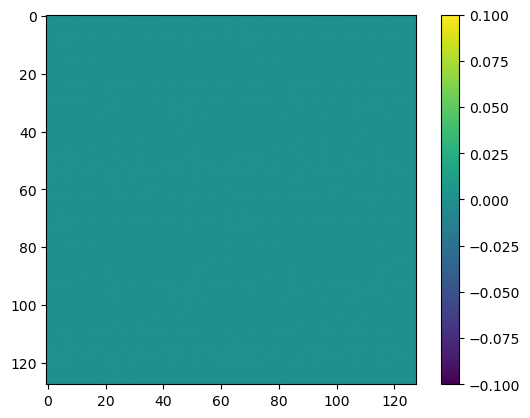

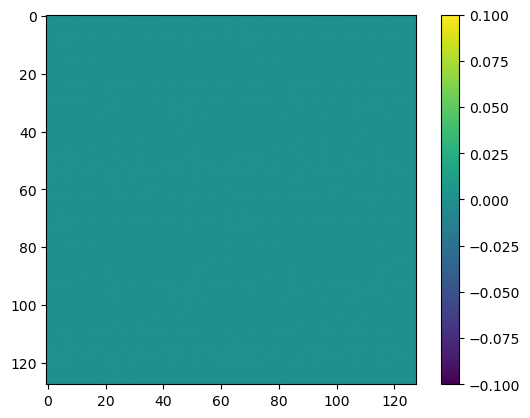

(128, 128, 128)


In [85]:
for sub in subjects:
#sub='Pat2block.nrrd'
    print(sub)
    
    #0.1 get raw feat
    path=raw_dir+sub
    raw=get_raw(path)
    print(raw.shape)
    
    #0.2 get ground truth
    path=gt_dir+sub
    gt=get_gt(path)
    print(gt.shape)
    
    '''#0.3 get prediction
    path=pred_dir+header+sub[:-4]+'pth.txt'
    pred=get_pred(path)
    print(pred.shape)
    '''
    #1.1 reconstruct prepocessing and filter out some ground truth
    raw0, gt0=greyscale_filter(raw,gt)
    print(raw0.shape,gt0.shape)
    
    
    #1.2 reconstruct prepocessing and get threshold to filter more ground truth
    input_size=128
    ratio = (input_size/raw0.shape[0],input_size/raw0.shape[1],input_size/raw0.shape[2])
    old_info = [raw0.max(),raw0.mean(),raw0.min(),raw0.std()]
    print('old: ', old_info)

    raw1 = zoom(raw0, ratio)  #z,y,x
    new_info = [raw1.max(),raw1.mean(),raw1.min(),raw1.std()]
    print('new: ', new_info)
    print(raw1.shape)
    
    old_threshold=400
    new_threshold  = get_threshold(old_threshold,old_info,new_info)
    print(new_threshold, old_threshold )  
    
    #2 get the index that is lower than threshold
    idxs=np.where(raw1<new_threshold)
    
    
    #3 seperate class into individual masks
    masks=seperate_class(gt) #(11, 154, 512, 512)
    
    #4 zoom each class seperately and drop out value using idxs and save it
    for i in range(1,11):
        org=masks[i]
        print(org.shape)
        ratio  = (128/org.shape[0],128/org.shape[1],128/org.shape[2])
        cube_128 = zoom(org, ratio)
        cube_128=np.round(cube_128)

        plt.imshow(cube_128[50])
        plt.colorbar()
        plt.show()
        
        cube_128[idxs]=0
        
        plt.imshow(cube_128[50])
        plt.colorbar()
        plt.show()


        print(cube_128.shape)
        path=write_dir+sub[:-4]+'/'+str(i)
        np.save(path,cube_128)

    

    
